#  Which 3 US cities will see the largest raw increase in population over the 20s, as judged by the 2030 census?
https://manifold.markets/market/which-3-us-cities-will-see-the-larg

This is just a largest raw increase, not the fastest growing, so larger cities should have an advantage over smaller, fast growing cities.

I will be using census places for cities.

To try and predict this I will look at the following:
 - Of the past 10 year periods that we have data for, which cities appeared in the top 3 most frequently?
    - Is it the same few cities over and over again?
 - Which cities have added the most population for the decade so far? (2020-2022)
    - Do these cities frequently appear in the top 3? 
 - Project the population using existing data to see which cities
    - probably just do a naive linear projection (potentially could use logarithmic if results seem ridiculous)

 Then I will try to make a judgment call using the overall vibes that the data is giving me.

### Load Libraries and Environmental Variables
Get your census key [here](https://api.census.gov/data/key_signup.html).

In [2]:
import os

import dotenv
import pandas
import requests

In [3]:
dotenv.load_dotenv()
census_api_key = os.getenv("CENSUS_API_KEY")

## Get Data
Get data from census API.  The 2005-2019,2021-2022 data is from the 1 year acs and the 2020 data is from the decennial census.  The ACS is a sample and has a margin of error, whereas the decennial census is a population count, but that shouldn't matter too much for this analysis.  It is possible to get more historic data from https://www.nhgis.org/, but this is a good start.

In [4]:
acs_params = {
    "get":"NAME,B01001_001E",
    "for": "place:*",
    "key": census_api_key,
}
dec_params = {
    "get":"NAME,P1_001N",
    "for": "place:*",
    "key": census_api_key,
}
years = range(2005, 2023)
data = {
    year: requests.get(
        url=(
            f"https://api.census.gov/data/{year}/acs/acs1" 
            if year != 2020 
            else f"https://api.census.gov/data/{year}/dec/dhc"
        ),
        params=acs_params if year != 2020 else dec_params,
    ).json()
    for year in years
}

In [5]:
df = pandas.concat([
    (
        pandas.DataFrame(data=year_data[1:], columns=year_data[0])
        .set_index(["state","place", "NAME"])
        .rename(columns={"B01001_001E": year, "P1_001N": year})
        .apply(pandas.to_numeric)
    )
    for year, year_data in data.items()
], axis=1)

In [6]:
# Calculate the change in population for each decade
decade_change = pandas.concat([
    (df[col + 10] - df[col]).rename(f"change {col} to {col + 10}")
    for col in df.columns
    if col + 10 in df.columns
], axis=1)

In [7]:
# Rank the change in population for each decade
rank = pandas.concat([
    decade_change[col].dropna().sort_values(ascending=False).rank(ascending=False)
    for col in decade_change.columns
], axis=1)

## What percentage of the time did each place rank in the top 3 for population change in each of the 8 decade periods?


In [19]:
(rank <= 3).sum(axis=1).sort_values(ascending=False).head(10)

state  place  NAME                          
48     35000  Houston city, Texas               6
36     51000  New York city, New York           5
48     27000  Fort Worth city, Texas            5
       65000  San Antonio city, Texas           3
       05000  Austin city, Texas                2
04     55000  Phoenix city, Arizona             2
37     12000  Charlotte city, North Carolina    1
48     56000  Pasadena city, Texas              0
06     60102  Redwood City city, California     0
44     19180  Cranston city, Rhode Island       0
dtype: int64

<Axes: ylabel='NAME'>

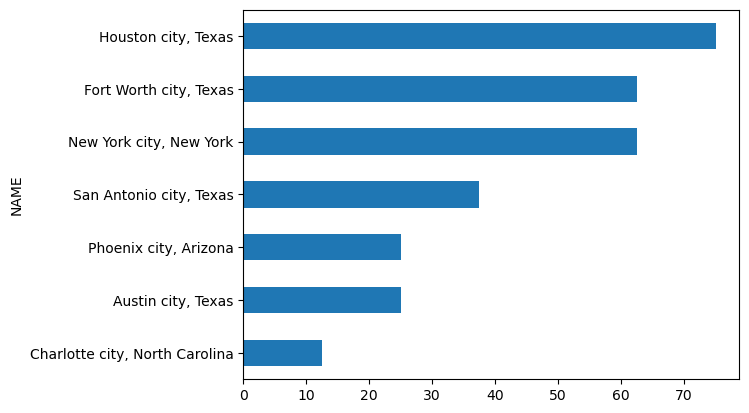

In [20]:
(
    rank
    .loc[(rank <= 3).any(axis=1)]
    .apply(lambda row: sum(row <= 3) / 8 * 100, axis=1)
    .reset_index()
    .set_index('NAME')[0]
    .sort_values(ascending=True)
    .tail(10)
    .plot(kind='barh')
)

## Which cities have added the most population from 2020-2022?

In [208]:
pop_2020_2022 = (
    (df[2022] - df[2020])
    .reset_index()
    .assign(rank=lambda x: x[0].sort_values(ascending=False).rank(ascending=False))
)

<Axes: ylabel='NAME'>

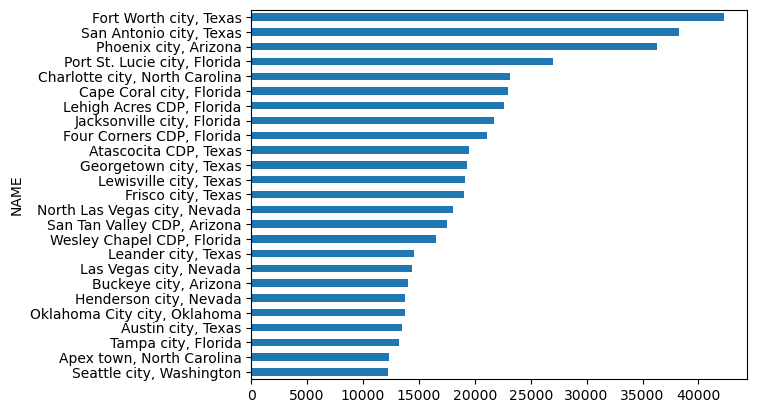

In [209]:
(
    pop_2020_2022
    .loc[~pop_2020_2022["NAME"].str.contains('Louisville/Jefferson')]
    .sort_values("rank")
    .head(25)
    .set_index('NAME')[0]
    .sort_values()
    .plot(kind='barh')
)

# Which cities are projected to add the most population?
Using a linear regression model.

In [23]:
import numpy
from sklearn.linear_model import LinearRegression

In [29]:
projection_years = list(range(2023, 2031))
df_projection = df.copy().dropna()

# Fit a linear model and project for each row
for index, row in df.dropna().iterrows():
    # Prepare the data for linear regression
    X = numpy.array(years).reshape(-1, 1)
    y = row.values.reshape(-1, 1)
    
    # Fit the linear regression model
    model = LinearRegression()
    model.fit(X, y)
    
    # Predict the values for the projection years
    X_proj = numpy.array(projection_years).reshape(-1, 1)
    y_proj = model.predict(X_proj)
    
    # Add the projected values to the DataFrame
    for i, year in enumerate(projection_years):
        df_projection.at[index, year] = y_proj[i, 0]


In [31]:
(df_projection[2030] - df_projection[2020]).sort_values(ascending=False).head(10)

state  place  NAME                          
48     65000  San Antonio city, Texas           235354.795666
       35000  Houston city, Texas               225547.654283
       27000  Fort Worth city, Texas            217776.252838
       05000  Austin city, Texas                202034.137255
37     12000  Charlotte city, North Carolina    187499.764018
04     55000  Phoenix city, Arizona             167830.839009
06     44000  Los Angeles city, California      142183.228414
53     63000  Seattle city, Washington          139757.440660
06     66000  San Diego city, California        136384.820777
39     18000  Columbus city, Ohio               134514.369797
dtype: float64